<a href="https://colab.research.google.com/github/wolandmargarita/generative-deep-learning-exercises/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Variational Auto Encoders (Generative_Deep_Learning_2nd_Edition Exercise, Chp. 3)

%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [4]:
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

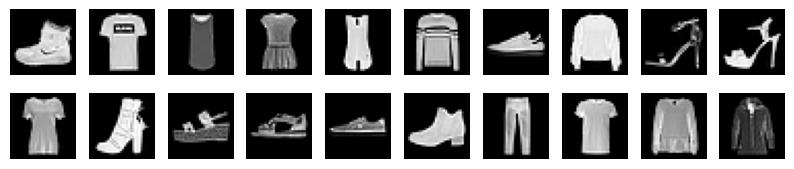

In [5]:

plt.figure(figsize=(10,2))
for i in range(20):
  plt.subplot(2, 10, i + 1)
  plt.imshow(x_train[i, :, :, 0], cmap="gray")
  plt.axis("off")
plt.show()

This class `Sampling` is implementing the reparameterization trick, which is commonly used in Variational Autoencoders (VAEs). In VAEs, you have a probabilistic encoder that maps inputs to a probability distribution in the latent space, typically modeled as a Gaussian distribution with mean (`z_mean`) and variance (`z_log_var`).

The purpose of the `Sampling` layer is to sample from this distribution to obtain a latent representation. However, directly sampling from the Gaussian distribution can introduce noise during backpropagation, making the training unstable. The reparameterization trick addresses this issue by separating out the randomness from the network, allowing gradients to flow through the deterministic path during training.

Here's a breakdown of what the `call` method is doing:

1. It takes `inputs`, which are assumed to be a tuple containing the mean (`z_mean`) and log variance (`z_log_var`) of the latent Gaussian distribution.
2. It first extracts the batch size and dimensionality of the latent space from `z_mean`.
3. It generates random noise (`epsilon`) from a standard normal distribution with the same shape as the batch size and dimensionality of `z_mean`.
4. It then computes the latent vector by adding the mean (`z_mean`) to the product of the exponential of half the log variance (`z_log_var`) and the random noise (`epsilon`). This is the reparameterization trick: `z = z_mean + exp(0.5 * z_log_var) * epsilon`.
5. Finally, it returns the sampled latent vector `z`.

During training, this layer introduces stochasticity in the latent representation through the noise term `epsilon`, but it ensures that gradients can flow through the mean and log variance parameters, thus enabling effective backpropagation and training of the VAE.

In [6]:
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # this is a placeholder for the decoder
x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (378.

For each convolutional filter, the parameters are calculated as (filter_height * filter_width * input_channels + 1) * output_channels.
In the provided example, the first Conv2D layer has 32 filters with a size of 3x3. The input has one channel, so each filter has (3 * 3 * 1 + 1) * 32 = 320 parameters.
Similarly, the second Conv2D layer has 64 filters, each with (3 * 3 * 32 + 1) * 64 = 18496 parameters.
The third Conv2D layer has 128 filters, each with (3 * 3 * 64 + 1) * 128 = 73856 parameters.

In [12]:
# Decoder

decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3,3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, padding="same", activation="relu")(x)

decoder_output = layers.Conv2D(
    CHANNELS,
    (3,3),
    strides=1,
    padding="same",
    activation="sigmoid",
    name="decoder_output"
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 8, 8, 128)         147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 32, 32, 32)        1846

In [13]:
# Autoencoder
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)  # decoder(encoder_output)
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_3 (Functional)        (None, 32, 32, 1)         2462

In [15]:
# Train the autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# Create a model and save the checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [ ]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

# Save the final models
autoencoder.save("./models/autoencoder")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

In [26]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

Example images from the dataset


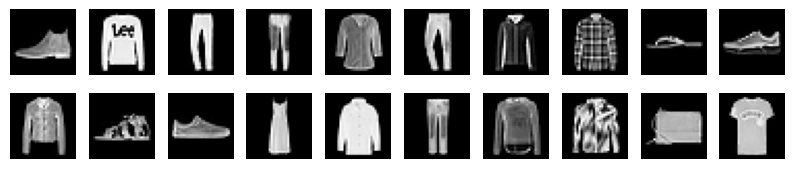

Reconstructed images


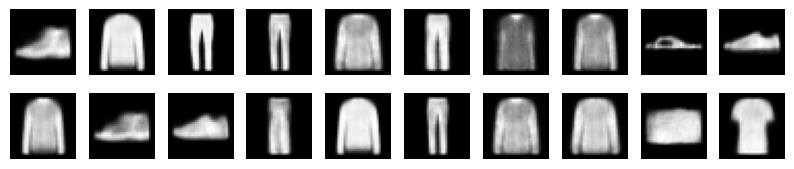

In [20]:
def display_images(images):
    '''
    Display a list of images in a grid format using Matplotlib.
        
    Args:
        images (list of numpy arrays): List of images to display.
    '''
    plt.figure(figsize=(10,2))
    for i in range(20):
        plt.subplot(2, 10, i + 1)
        plt.imshow(images[i, :, :, 0], cmap="gray")
        plt.axis("off")
    plt.show()

print("Example images from the dataset")
display_images(example_images)
print("Reconstructed images")
display_images(predictions)

157/157 [==============================] - 1s 4ms/step


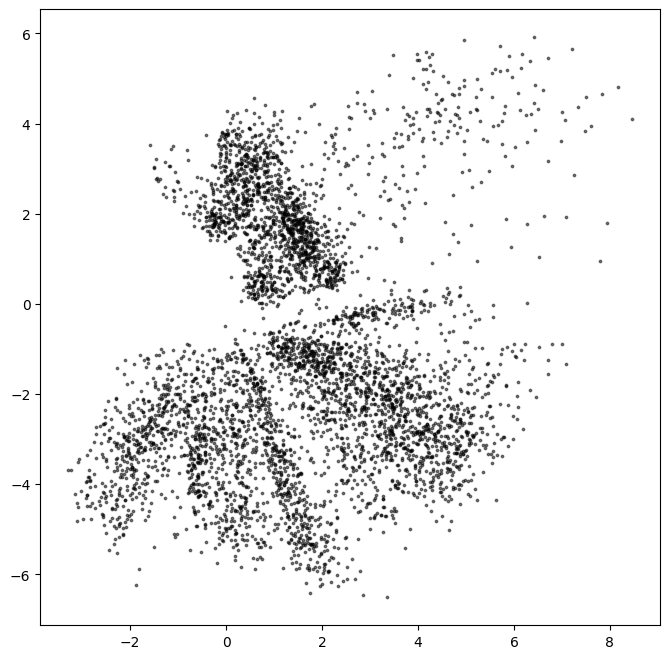

In [24]:
# Visualizing the latent space

embeddings = encoder.predict(example_images)

plt.figure(figsize=(8,8))
plt.scatter(embeddings[:,0], embeddings[:,1], c="black", alpha=0.5, s=3)
plt.show()

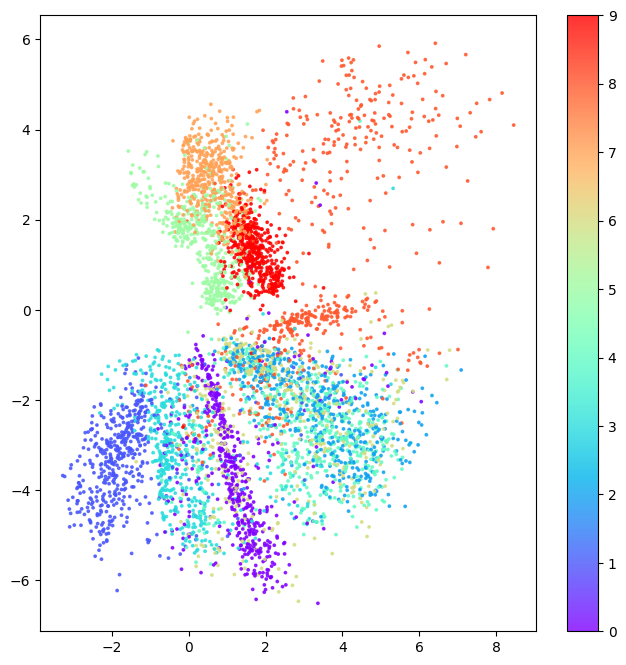

In [27]:
# Colour the embeddings by their label (clothing type - see table)
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()